<a href="https://colab.research.google.com/github/thunderhoser/cira_ml_short_course/blob/master/lecture04_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 4: Fully connected neural networks

This notebook was used for the CIRA (Cooperative Institute for Research in the Atmosphere) machine-learning short course in Fall 2020.

If you use code from this notebook, please cite it as follows.

Lagerquist, Ryan, and David John Gagne II, 2020: "Lecture 4: Fully connected neural networks". CIRA (Cooperative Institute for Research in the Atmosphere) machine-learning short course, https://github.com/thunderhoser/cira_ml_short_course/.

# References

This notebook refers to a few publications, listed below.  Schwartz *et al.* (2015) documents the dataset used.

Breiman, L., 2001: "Random forests." *Machine Learning*, **45**, 5–32, https://doi.org/10.1023/A:1010933404324.

Lakshmanan, V., C. Karstens, J. Krause, K. Elmore, A. Ryzhkov, and S. Berkseth, 2015: "Which polarimetric variables are important for weather/no-weather discrimination?" *Journal of Atmospheric and Oceanic Technology*, **32**, 1209-1223, https://doi.org/10.1175/JTECH-D-13-00205.1.

McGovern, A., R. Lagerquist, D. Gagne, G. Jergensen, K. Elmore, C. Homeyer, and T. Smith, 2019: "Making the black box more transparent: Understanding the physical implications of machine learning." *Bulletin of the American Meteorological Society*, **100 (11)**, 2175-2199, https://doi.org/10.1175/BAMS-D-18-0195.1.

Schwartz, C., G. Romine, M. Weisman, R. Sobash, K. Fossell, K. Manning, and S. Trier, 2015: "A real-time convection-allowing ensemble prediction system initialized by mesoscale ensemble Kalman filter analyses." *Weather and Forecasting*, **30 (5)**, 1158-1181, https://doi.org/10.1175/WAF-D-15-0013.1.

Simonyan, K., A. Vedaldi, and A. Zisserman, 2014: "Deep inside convolutional networks: Visualising image classification models and saliency maps." *arXiv e-prints*, **1312**, https://arxiv.org/abs/1312.6034.

Srivastava, N., G. Hinton, A. Krizhevsky, I. Sutskever, and R. Salakhutdinov, 2014: "Dropout: A simple way to prevent neural networks from overfitting." *Journal of Machine Learning Research*, **15 (1)**, 1929-1958.

# <font color='red'>Clone the Git repository (required)</font>

- **Please note**: when a section title is in <font color='red'>red</font>, that means the code cell below is required.
- In other words, if you don't run the code cell below, subsequent code cells might not work.

In [ ]:
import os
import shutil

if os.path.isdir('course_repository'):
    shutil.rmtree('course_repository')

!git clone https://github.com/thunderhoser/cira_ml_short_course course_repository
!cd course_repository; python setup.py install

Cloning into 'course_repository'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 401 (delta 17), reused 34 (delta 8), pack-reused 356
Receiving objects: 100% (401/401), 104.26 MiB | 31.47 MiB/s, done.
Resolving deltas: 100% (227/227), done.
running install
running bdist_egg
running egg_info
creating cira_ml_short_course.egg-info
writing cira_ml_short_course.egg-info/PKG-INFO
writing dependency_links to cira_ml_short_course.egg-info/dependency_links.txt
writing requirements to cira_ml_short_course.egg-info/requires.txt
writing top-level names to cira_ml_short_course.egg-info/top_level.txt
writing manifest file 'cira_ml_short_course.egg-info/SOURCES.txt'
writing manifest file 'cira_ml_short_course.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/cira_ml_short_course
cop

# <font color='red'>Import packages (required)</font>

The next two cells import all packages used in the notebook.

In [ ]:
import sys

sys.path.append('/content/data/')
sys.path.append('/content/course_repository/')
sys.path.append('/content/course_repository/cira_ml_short_course/')
sys.path.append('/content/course_repository/cira_ml_short_course/utils/')

In [ ]:
%matplotlib inline
import copy
import os.path
import warnings
import numpy
import keras
from matplotlib import pyplot
import tensorflow.compat.v1 as tf
from cira_ml_short_course.utils import utils
from cira_ml_short_course.plotting import permutation_plotting

tf.disable_v2_behavior()
warnings.filterwarnings('ignore')

SEPARATOR_STRING = '\n\n' + '*' * 50 + '\n\n'
MINOR_SEPARATOR_STRING = '\n\n' + '-' * 50 + '\n\n'

DATA_DIRECTORY_NAME = '/content/data/track_data_ncar_ams_3km_csv_small'

Instructions for updating:
non-resource variables are not supported in the long term


# <font color='red'>Prevent auto-scrolling (required)</font>

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# <font color='red'>Download input data (required)</font>

The next cell downloads all input data used in this notebook.

In [ ]:
!python /content/course_repository/download_tabular_data.py

Unzipping file: "data/track_data_ncar_ams_3km_csv_small.tar.gz"...


# <font color='red'>Read input data (required)</font>

The next cell reads all input data for this notebook into memory.

In [ ]:
training_file_names = utils.find_tabular_files(
    directory_name=DATA_DIRECTORY_NAME, first_date_string='20100101',
    last_date_string='20141231'
)
validation_file_names = utils.find_tabular_files(
    directory_name=DATA_DIRECTORY_NAME, first_date_string='20150101',
    last_date_string='20151231'
)
testing_file_names = utils.find_tabular_files(
    directory_name=DATA_DIRECTORY_NAME, first_date_string='20160101',
    last_date_string='20171231'
)

(training_metadata_table, training_predictor_table_denorm,
 training_target_table
) = utils.read_many_tabular_files(training_file_names)
print(MINOR_SEPARATOR_STRING)

(validation_metadata_table, validation_predictor_table_denorm,
 validation_target_table
) = utils.read_many_tabular_files(validation_file_names)
print(MINOR_SEPARATOR_STRING)

(testing_metadata_table, testing_predictor_table_denorm,
 testing_target_table
) = utils.read_many_tabular_files(testing_file_names)
print(MINOR_SEPARATOR_STRING)

print('Variables in metadata are as follows:\n{0:s}'.format(
    str(list(training_metadata_table))
))

print('\nPredictor variables are as follows:\n{0:s}'.format(
    str(list(training_predictor_table_denorm))
))

print('\nTarget variable is as follows:\n{0:s}'.format(
    str(list(training_target_table))
))

first_predictor_name = list(training_predictor_table_denorm)[0]
these_predictor_values = (
    training_predictor_table_denorm[first_predictor_name].values[:10]
)

message_string = (
    '\nValues of predictor variable "{0:s}" for the first training '
    'examples:\n{1:s}'
).format(first_predictor_name, str(these_predictor_values))
print(message_string)

target_name = list(training_target_table)[0]
these_target_values = training_target_table[target_name].values[:10]

message_string = (
    '\nValues of target variable for the first training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101024-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101122-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110201-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110308-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110326-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110404-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110414-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110420-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_N

# <font color='red'>Normalization (required)</font>

- The next cell normalizes predictor variables in all three datasets (training, validation, and testing).
- Recall from Lecture 2 that the normalization parameters used (mean and standard deviation for each predictor variable) are computed from the training data only.
- This ensures that information from the validation and testing data have not "leaked" into the training data.

In [ ]:
predictor_names = list(training_predictor_table_denorm)
these_predictor_values = (
    training_predictor_table_denorm[predictor_names[0]].values[:10]
)

message_string = (
    'Original values of "{0:s}" for the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

training_predictor_table, normalization_dict = utils.normalize_predictors(
    predictor_table=copy.deepcopy(training_predictor_table_denorm)
)

these_predictor_values = (
    training_predictor_table[predictor_names[0]].values[:10]
)

message_string = (
    '\nNormalized values of "{0:s}" for the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

training_predictor_table_denorm = utils.denormalize_predictors(
    predictor_table=copy.deepcopy(training_predictor_table),
    normalization_dict=normalization_dict
)

these_predictor_values = (
    training_predictor_table_denorm[predictor_names[0]].values[:10]
)

message_string = (
    '\n*De*normalized values (should equal original values) of "{0:s}" for '
    'the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

validation_predictor_table, _ = utils.normalize_predictors(
    predictor_table=copy.deepcopy(validation_predictor_table_denorm),
    normalization_dict=normalization_dict
)

testing_predictor_table, _ = utils.normalize_predictors(
    predictor_table=copy.deepcopy(testing_predictor_table_denorm),
    normalization_dict=normalization_dict
)

Original values of "composite_refl_mean_dbz" for the first training examples:
[42.71822 47.09285 45.53852 44.30976 44.64383 44.33831 45.73259 43.69113
 45.3804  47.31104]

Normalized values of "composite_refl_mean_dbz" for the first training examples:
[-1.03619508  0.06182963 -0.32830456 -0.63672124 -0.55287024 -0.62955524
 -0.27959332 -0.79199632 -0.36799241  0.11659495]

*De*normalized values (should equal original values) of "composite_refl_mean_dbz" for the first training examples:
[42.71822 47.09285 45.53852 44.30976 44.64383 44.33831 45.73259 43.69113
 45.3804  47.31104]


# <font color='red'>Binarization (required)</font>

- The next cell binarizes the target variable (max future vorticity in s$^{-1}$).
- **However, fully connected networks can also perform regression.**

In [ ]:
binarization_threshold = utils.get_binarization_threshold(
    tabular_file_names=training_file_names, percentile_level=90.
)
print(MINOR_SEPARATOR_STRING)

these_target_values = (
    training_target_table[utils.TARGET_NAME].values[1030:1050]
)

message_string = (
    'Real-numbered target values for a few training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

training_target_values = utils.binarize_target_values(
    target_values=training_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold
)
training_target_table = training_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: training_target_values}
)

print('\nBinarization threshold = {0:.3e} s^-1'.format(
    binarization_threshold
))

these_target_values = (
    training_target_table[utils.BINARIZED_TARGET_NAME].values[1030:1050]
)

message_string = (
    '\nBinarized target values for the same training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

validation_target_values = utils.binarize_target_values(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold
)
validation_target_table = validation_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: validation_target_values}
)

testing_target_values = utils.binarize_target_values(
    target_values=testing_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold
)
testing_target_table = testing_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: testing_target_values}
)

Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101024-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101122-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110201-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110308-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110326-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110404-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110414-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110420-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_N

# Fully connected neural networks (FNN)

## Theory (part 1 of 4)

 - They are called "fully connected" because each neuron in layer $k$ is connected to all neurons in the previous layer ($k - 1$) and all neurons in the next layer ($k + 1$).
 - Sometimes fully connected networks are called "dense networks".
<br><br>
 - **Each neuron in the network performs its own linear regression**, with weights learned during training.
 - **Between each pair of adjacent layers, there is a non-linear "activation function,"** which allows the network to learn non-linear relationships.
 - Without the non-linear activation functions, the network could learn only linear relationships, because any series of linear transformations is a linear transformation.
<br><br>

<center><img src="https://raw.githubusercontent.com/thunderhoser/cira_ml_short_course/master/dnn_schematic.png" width="750" /></center>
<center>(Image credit: https://knowingneurons.com/2018/04/11/artificial-neural-network/neural-network-schematic/)</center>

## Theory (part 2 of 4)

 - **FNNs contain 3 types of layers:**
   - The input layer passes predictors (weather variables) into the network.
   - Hidden layers transform predictors (weather variables) into different representations (or "abstractions" or "features").
   - The output layer transforms features into predictions.
<br><br>

 - For univariate regression (predicting one scalar value), the output layer contains one neuron.
 - For multivariate regression (predicting $N$ scalar values), the output layer contains $N$ neurons.
 - For binary classification, the output layer contains one neuron (probability of event, *e.g.,* strong rotation).
 - For multiclass classification ($K$ classes), the output layer contains $K$ neurons; the value at each neuron is considered a class probability.
<br><br>

 - **Each layer (both hidden and output layers) has its own neurons and its own non-linear activation function.**
 - The architecture (number of layers, number of neurons in each layer, activation functions) is decided *a priori* and cannot change during training.
 - In other words, these values are **hyperparameters**.
<br><br>

 - **Each neuron has its own linear-regression equation, including weights and a bias coefficient.**
 - These weights and biases are the model **parameters** (they are learned during training).

## Theory (part 3 of 4)

**The linear-regression equation for each neuron is as follows:**

<center>$f_i^{(k)} = a^{(k)} \bigg\lbrace b_i^{(k)} + \sum\limits_{j = 1}^{j = N^{(k - 1)}} w_{ij}^{(k)} f_j^{(k - 1)} \bigg\rbrace$</center>

 - $b_i^{(k)}$ = bias for $i^{\textrm{th}}$ neuron in $k^{\textrm{th}}$ layer
 - $w_{ij}^{(k)}$ = weight connecting $i^{\textrm{th}}$ neuron in $k^{\textrm{th}}$ layer to $j^{\textrm{th}}$ neuron in $(k - 1)^{\textrm{th}}$ layer
 - $f_j^{(k - 1)}$ = feature value at $j^{\textrm{th}}$ neuron in $(k - 1)^{\textrm{th}}$ layer
 - $N^{(k - 1)}$ = number of neurons in $(k - 1)^{\textrm{th}}$ layer
 - $a^{(k)}$ = non-linear activation function for $k^{\textrm{th}}$ layer
 - $f_i^{(k)}$ = feature value at $i^{\textrm{th}}$ neuron in $k^{\textrm{th}}$ layer
<br><br>

<center><img src="https://raw.githubusercontent.com/thunderhoser/cira_ml_short_course/master/dnn_schematic_ryan.jpg" width="750" /></center>
<br><br>

**In the figure above, the linear-regression equation for the top-right neuron is as follows:**

<center>$f_1^{(4)} = a^{(4)} \bigg\lbrace b_1^{(4)} + \sum\limits_{j = 1}^{j = 3} w_{1j}^{(4)} f_j^{(3)} \bigg\rbrace = a^{(4)} \bigg\lbrace b_1^{(4)} + w_{11}^{(4)} f_1^{(3)} + w_{12}^{(4)} f_2^{(3)} + w_{13}^{(4)} f_3^{(3)} \bigg\rbrace$</center>
<br><br>

 - The weights and biases are adjusted during training to minimize the error or "loss function".
 - For regression (univariate or multivariate), the loss function is typically mean squared error (MSE).  See discussion of linear regression in Lecture 2.
 - For binary classification, the loss function is typically cross-entropy.  See discussion of logistic regression in Lecture 3.
 - For multiclass classification, the loss function is typically multiclass cross-entropy (similar to binary cross-entropy).

## Theory (part 4 of 4)

 - There are many types of activation functions, and it can be hard to choose.
<br><br>
 - **Some general guidelines in choosing the activation function for the output layer**:
   - Binary classification: sigmoid (forces output, which is a probability, to range from $0\ldots1$)
   - Multiclass classification: softmax (forces outputs, which are probabilities, to be positive and sum to 1.0)
   - Unbounded regression (output can range from $-\infty\ldots\infty$): linear (same as no activation function)
   - Bounded regression (output must be $>= 0$): rectified linear unit (ReLU)
<br><br>

 - **For the hidden layers, people typically use ReLU or leaky ReLU.**
 - However, other types of ReLU are sometimes beneficial.
<br><br>

 - **The next cell plots all activation functions mentioned here.**

## Plots of activation functions

The following cell plots all activation functions mentioned above, except softmax, which cannot be plotted in 2-D space.  For $K$-class classification, the softmax function has $K$ inputs and $K$ outputs.

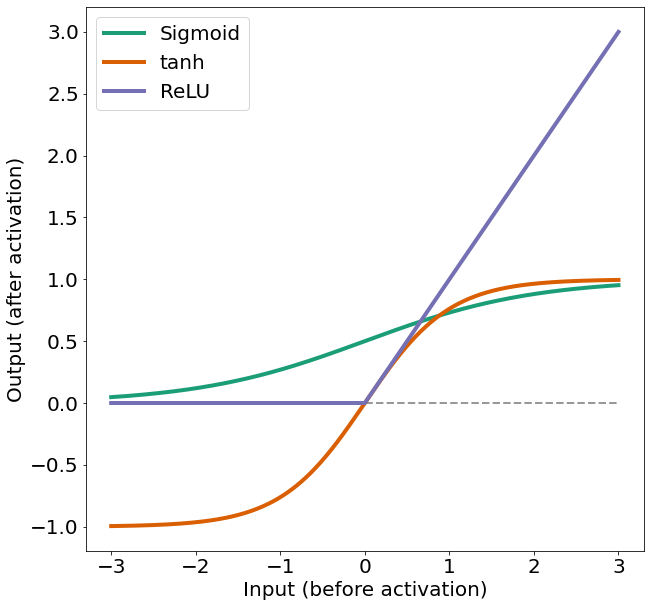

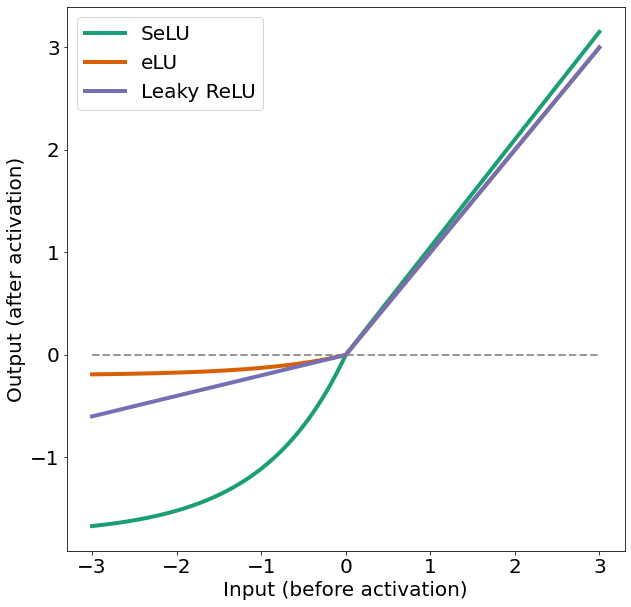

In [ ]:
utils.plot_basic_activations()
print('\n\n')
utils.plot_fancy_activations()

## Dropout regularization

 - **Dropout, like L$_1$ and L$_2$, is a type of regularization.**
 - Regularization encourages a simpler model, which reduces the risk of overfitting the training data.
<br><br>

 - **To my knowledge, dropout is used only in neural networks** (fully connected and otherwise).
 - Dropout can be applied to a fully connected or convolutional layer (you will learn about convolutional layers in Lecture 5).
 - **For a given layer, dropout randomly omits fraction $d$ of weights when predicting each training example, where $d$ is a hyperparameter.**
 - **This forces redundancies in the behaviour of weights within the same layer** (because for a given training example, any weight may be dropped out, forcing the other weights to "fill in"), which reduces overfitting.
<br><br>

 - **Typically, dropout is used only during training.**
 - Thus, dropout is not used for validation, testing, or application to future data ("in the wild").
 - However, dropout may be used on non-training data for uncertainty quantification (*i.e.*, randomly drop out weights 1000 times and look at the distribution of predictions).
<br><br>

<center><img src="https://raw.githubusercontent.com/thunderhoser/cira_ml_short_course/master/dropout_schematic.png" width="750" /></center>
<center>(Image credit: Figure 1 of Srivastava et al. 2014)</center>

## Batch normalization

 - **Batch normalization is often applied after the activation function for each hidden layer.**
 - **Batch normalization transforms each feature to a Gaussian distribution, with mean of 0 and standard deviation of 1.**
   - The desired mean and standard deviation can be changed (these are hyperparameters), but 0 and 1, respectively, are the defaults.
   - Batch normalization is done independently for each batch of training examples.
<br><br>

 - Even if the original predictors (weather variables) are transformed to a Gaussian distribution, operations performed inside the neural network usually draw the distribution away from Gaussian.
 - Batch normalization restores this Gaussian distribution.
 - Gaussian distributions have "nice properties," which speed up training and mitigate the vanishing-gradient problem (you can read more about this in Ioffe and Szegedy 2015).
<br><br>

<center><img src="https://raw.githubusercontent.com/thunderhoser/cira_ml_short_course/master/batch_norm_schematic.png" width="750" /></center>
<center>(Image credit: https://deepai.org/machine-learning-glossary-and-terms/batch-normalization)</center>

# Basic example

## Architecture

The next cell creates an FNN with the following hyperparameters:

 - Dropout rate of 0.5 for hidden layers
 - Dropout rate of 0 for output layer
 - Activation function for hidden layers = leaky ReLU with slope of 0.2
 - Activation function for output layer = sigmoid (binary classification)
 - No L$_1$ regularization
 - L$_2$ regularization (strength of 0.001) for all layers
<br><br>

The other hyperparameters, which are all architectural (*i.e.*, layer types and sizes), are shown in the table printed below.

In [ ]:
num_predictors = len(list(training_predictor_table))
basic_dense_net_object = utils.setup_dense_net(num_predictors=num_predictors)
# basic_dense_net_object.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              42000     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1000)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1000)              4000      
_________________________________________________________________
dense_1 (Dense)              (None, 178)               178178    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 178)              

## Training

The next cell trains the FNN we just created.

In [ ]:
utils.train_dense_net(
    model_object=basic_dense_net_object,
    output_dir_name='/content/models/basic_dense_net',
    # num_epochs=100,
    num_epochs=20,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table,
    validation_predictor_table=validation_predictor_table,
    validation_target_table=validation_target_table
)

Train on 76377 samples, validate on 25392 samples
Epoch 1/20
75776/76377 [============================>.] - ETA: 0s - loss: 1.0520 - accuracy: 0.0678 - binary_accuracy: 0.5846 - binary_csi: 0.1406 - binary_frequency_bias: 4.5387 - binary_pod: 0.6758 - binary_pofd: 0.4254 - binary_peirce_score: 0.2504 - binary_success_ratio: 0.1509 - binary_focn: 0.9407WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.

Epoch 00001: val_loss improved from inf to 0.81290, saving model to /content/models/basic_dense_net/model_epoch=001_val-loss=0.812899.h5
76377/76377 [==============================] - 6s 82us/sample - loss: 1.0509 - accuracy: 0.0677 - binary_accuracy: 0.5851 - binary_csi: 0.1406 - binary_fr

## Evaluation

The next cell evaluates the FNN we just trained.

Applying neural net to examples 1-1024 of 76377...
Applying neural net to examples 1025-2048 of 76377...
Applying neural net to examples 2049-3072 of 76377...
Applying neural net to examples 3073-4096 of 76377...
Applying neural net to examples 4097-5120 of 76377...
Applying neural net to examples 5121-6144 of 76377...
Applying neural net to examples 6145-7168 of 76377...
Applying neural net to examples 7169-8192 of 76377...
Applying neural net to examples 8193-9216 of 76377...
Applying neural net to examples 9217-10240 of 76377...
Applying neural net to examples 10241-11264 of 76377...
Applying neural net to examples 11265-12288 of 76377...
Applying neural net to examples 12289-13312 of 76377...
Applying neural net to examples 13313-14336 of 76377...
Applying neural net to examples 14337-15360 of 76377...
Applying neural net to examples 15361-16384 of 76377...
Applying neural net to examples 16385-17408 of 76377...
Applying neural net to examples 17409-18432 of 76377...
Applying neura

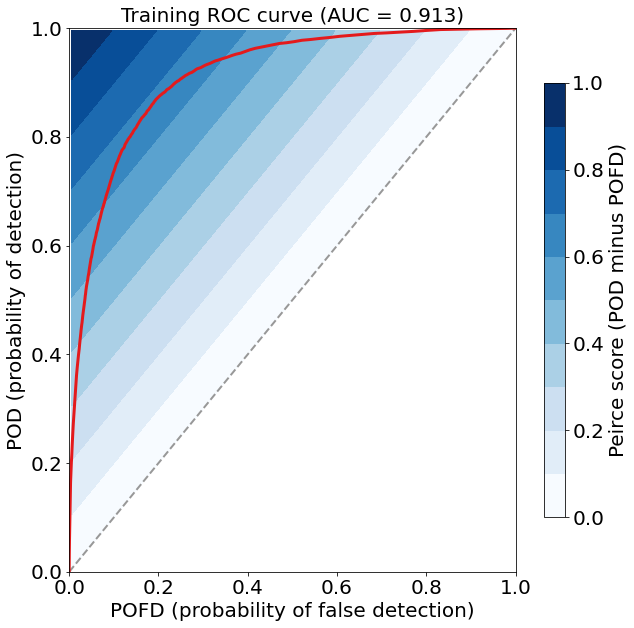

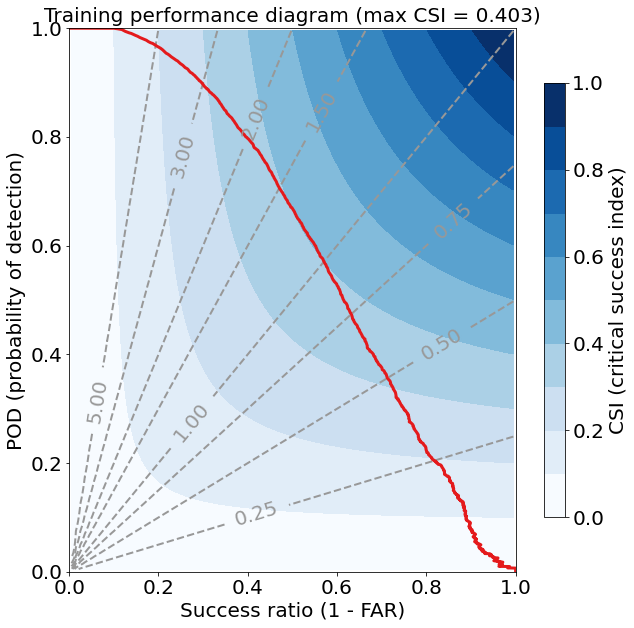

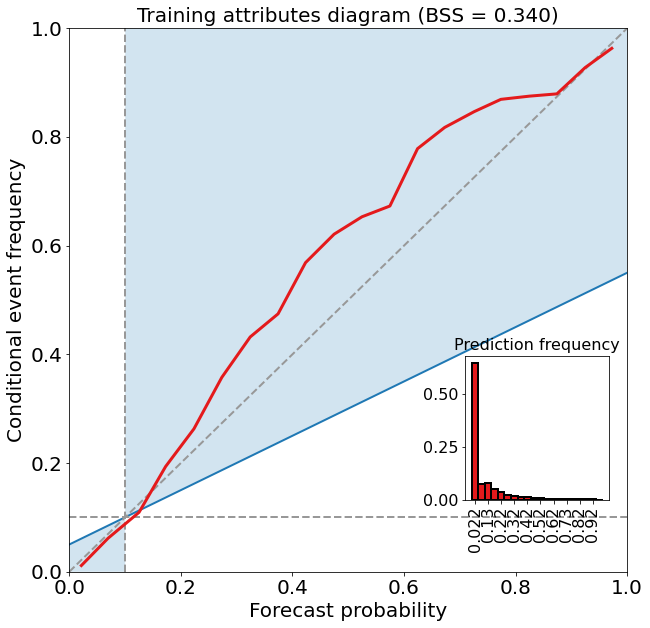

Training max Peirce score (POD - POFD) = 0.675
Training AUC (area under ROC curve) = 0.913
Training max CSI (critical success index) = 0.403
Training Brier score = 0.060
Training Brier skill score (improvement over climatology) = 0.340
Applying neural net to examples 1-1024 of 25392...
Applying neural net to examples 1025-2048 of 25392...
Applying neural net to examples 2049-3072 of 25392...
Applying neural net to examples 3073-4096 of 25392...
Applying neural net to examples 4097-5120 of 25392...
Applying neural net to examples 5121-6144 of 25392...
Applying neural net to examples 6145-7168 of 25392...
Applying neural net to examples 7169-8192 of 25392...
Applying neural net to examples 8193-9216 of 25392...
Applying neural net to examples 9217-10240 of 25392...
Applying neural net to examples 10241-11264 of 25392...
Applying neural net to examples 11265-12288 of 25392...
Applying neural net to examples 12289-13312 of 25392...
Applying neural net to examples 13313-14336 of 25392...
Ap

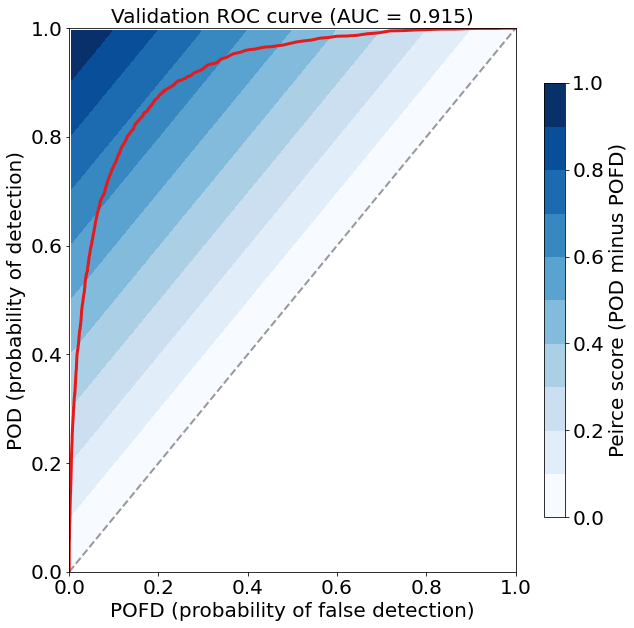

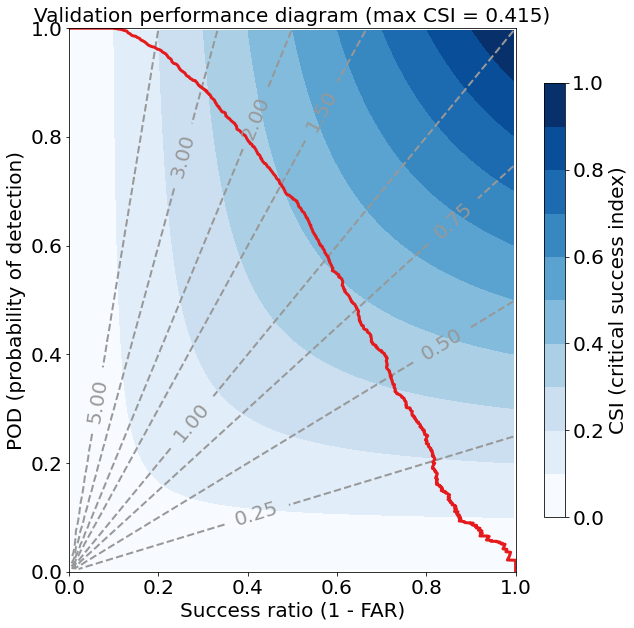

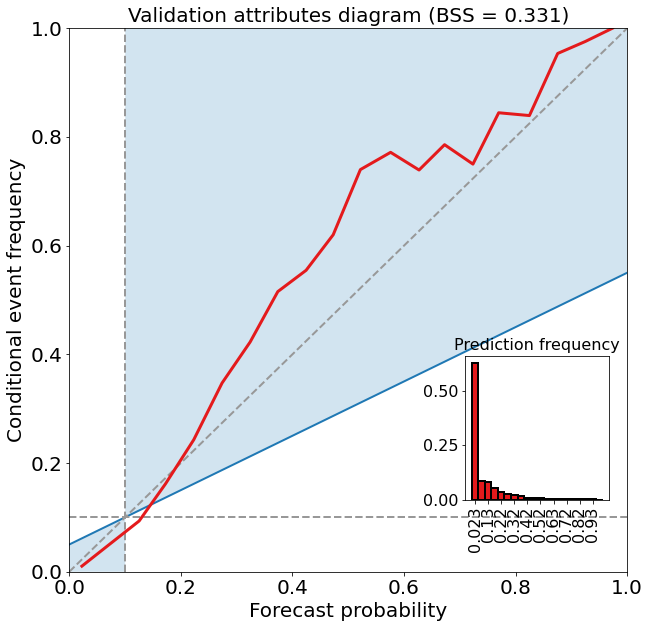

Validation max Peirce score (POD - POFD) = 0.677
Validation AUC (area under ROC curve) = 0.915
Validation max CSI (critical success index) = 0.415
Validation Brier score = 0.060
Validation Brier skill score (improvement over climatology) = 0.331


In [ ]:
training_probabilities = utils.apply_neural_net(
    model_object=basic_dense_net_object,
    predictor_matrix=training_predictor_table.to_numpy(),
    num_examples_per_batch=1024, verbose=True
)
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

_ = utils.eval_binary_classifn(
    observed_labels=
    training_target_table[utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=training_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='training'
)

validation_probabilities = utils.apply_neural_net(
    model_object=basic_dense_net_object,
    predictor_matrix=validation_predictor_table.to_numpy(),
    num_examples_per_batch=1024, verbose=True
)

_ = utils.eval_binary_classifn(
    observed_labels=
    validation_target_table[utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=validation_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='validation'
)

# Tuning hyperparameters

 - **I have found that two of the most important hyperparameters for neural networks are the dropout rate and L$_2$ strength.**
 - Both dropout and L$_2$ are regularization methods, which control overfitting.
 - Controlling overfitting is important in domains with noisy/uncertain data, which often include atmospheric science.
<br><br>

**Recall the four steps of any hyperparameter experiment:**

 1. Choose the values to be attempted.  Let $d$ be the dropout rate and $\lambda_2$ be the L$_2$-regularization strength.  We will try $d \in \lbrace 0, 0.25, 0.5, 0.75 \rbrace$ and $\lambda_2 \in \lbrace 10^{-4}, 10^{-3.5}, 10^{-3}, 10^{-2.5}, 10^{-2} \rbrace$.
 2. Train a model with each combination.
 3. Evaluate each model on the validation data.
 4. Select the model that performs best on validation data.  Here we will define "best" as that with the highest Brier skill score.

## Training

The next cell performs steps 1 and 2 of the hyperparameter experiment (defining the values to be attempted and training the models).

In [ ]:
dropout_rates = numpy.array([0, 0.25, 0.5, 0.75])
l2_weights = numpy.logspace(-4, -2, num=5)

num_dropout_rates = len(dropout_rates)
num_l2_weights = len(l2_weights)

validation_auc_matrix = numpy.full(
    (num_dropout_rates, num_l2_weights), numpy.nan
)

validation_max_csi_matrix = validation_auc_matrix + 0.
validation_bs_matrix = validation_auc_matrix + 0.
validation_bss_matrix = validation_auc_matrix + 0.

training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)
num_predictors = len(list(training_predictor_table))

for i in range(num_dropout_rates):
    for j in range(num_l2_weights):
        dropout_rate_by_layer = numpy.concatenate((
            numpy.full(4, dropout_rates[i]), numpy.array([0.])
        ))
        output_dir_name = (
            '/content/models/dense_net_hyperparam_experiment/'
            'dropout-rate={0:.2f}_l2-weight={1:.6f}'
        ).format(dropout_rates[i], l2_weights[j])

        model_object = utils.setup_dense_net(
            num_predictors=num_predictors,
            dropout_rates=dropout_rate_by_layer,
            l2_weight=l2_weights[j]
        )

        utils.train_dense_net(
            model_object=model_object,
            output_dir_name=output_dir_name,
            num_epochs=20,
            training_predictor_table=training_predictor_table,
            training_target_table=training_target_table,
            validation_predictor_table=validation_predictor_table,
            validation_target_table=validation_target_table
        )

        these_validation_probs = utils.apply_neural_net(
            model_object=model_object,
            predictor_matrix=validation_predictor_table.to_numpy(),
            num_examples_per_batch=1024, verbose=True
        )

        this_evaluation_dict = utils.eval_binary_classifn(
            observed_labels=
            validation_target_table[utils.BINARIZED_TARGET_NAME].values,
            forecast_probabilities=these_validation_probs,
            training_event_frequency=training_event_frequency,
            create_plots=False, verbose=False
        )

        validation_auc_matrix[i, j] = this_evaluation_dict[utils.AUC_KEY]
        validation_max_csi_matrix[i, j] = (
            this_evaluation_dict[utils.MAX_CSI_KEY]
        )
        validation_bs_matrix[i, j] = (
            this_evaluation_dict[utils.BRIER_SCORE_KEY]
        )
        validation_bss_matrix[i, j] = (
            this_evaluation_dict[utils.BRIER_SKILL_SCORE_KEY]
        )

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              42000     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 1000)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1000)              4000      
_________________________________________________________________
dense_6 (Dense)              (None, 178)               178178    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 178)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 178)              

## Validation

The next cell performs step 3 of the hyperparameter experiment (evaluates each model on the validation data).

Text(0.5, 1.0, 'Brier skill score on validation data')

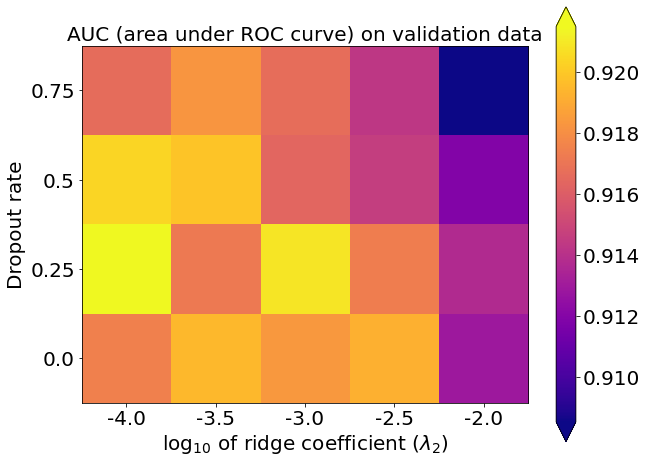

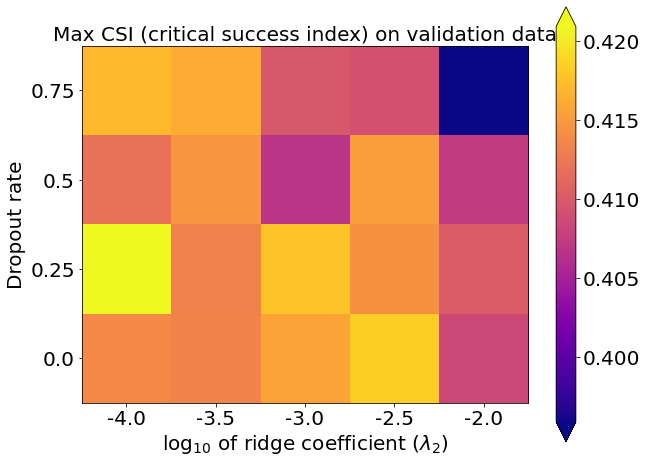

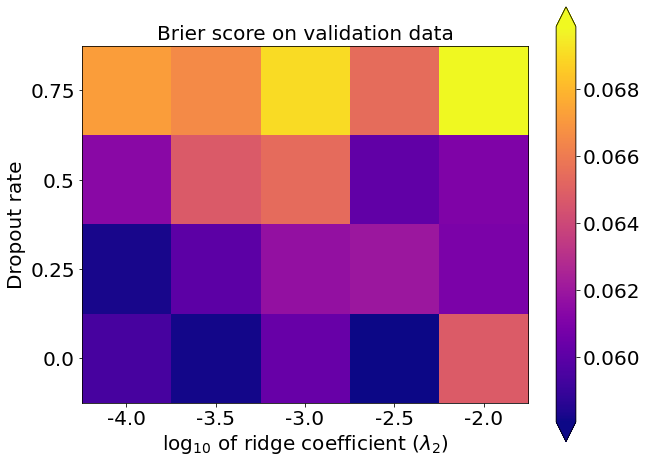

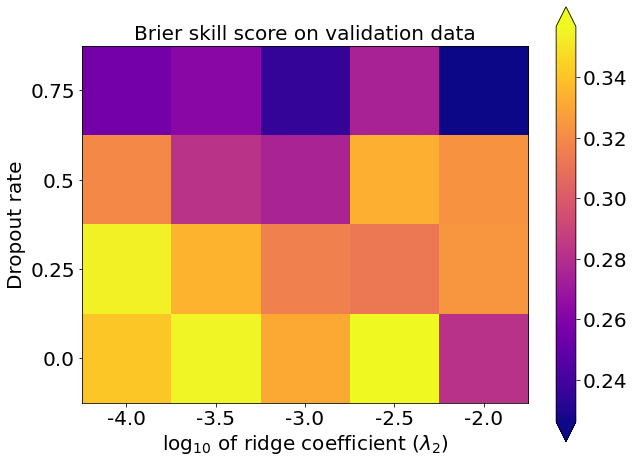

In [ ]:
utils.plot_scores_2d(
    score_matrix=validation_auc_matrix,
    min_colour_value=numpy.percentile(validation_auc_matrix, 1.),
    max_colour_value=numpy.percentile(validation_auc_matrix, 99.),
    x_tick_labels=numpy.log10(l2_weights),
    y_tick_labels=dropout_rates
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel('Dropout rate')
pyplot.title('AUC (area under ROC curve) on validation data')

utils.plot_scores_2d(
    score_matrix=validation_max_csi_matrix,
    min_colour_value=numpy.percentile(validation_max_csi_matrix, 1.),
    max_colour_value=numpy.percentile(validation_max_csi_matrix, 99.),
    x_tick_labels=numpy.log10(l2_weights),
    y_tick_labels=dropout_rates
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel('Dropout rate')
pyplot.title('Max CSI (critical success index) on validation data')

utils.plot_scores_2d(
    score_matrix=validation_bs_matrix,
    min_colour_value=numpy.percentile(validation_bs_matrix, 1.),
    max_colour_value=numpy.percentile(validation_bs_matrix, 99.),
    x_tick_labels=numpy.log10(l2_weights),
    y_tick_labels=dropout_rates
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel('Dropout rate')
pyplot.title('Brier score on validation data')

utils.plot_scores_2d(
    score_matrix=validation_bss_matrix,
    min_colour_value=numpy.percentile(validation_bss_matrix, 1.),
    max_colour_value=numpy.percentile(validation_bss_matrix, 99.),
    x_tick_labels=numpy.log10(l2_weights),
    y_tick_labels=dropout_rates
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel('Dropout rate')
pyplot.title('Brier skill score on validation data')

## Selection

The next cell performs step 4 of the hyperparameter experiment (select model).

Best validation BSS = 0.357 ... corresponding dropout rate = 0.00 ... L_2 weight = 10^-2.5
Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 41)]              0         
_________________________________________________________________
dense_106 (Dense)            (None, 1000)              42000     
_________________________________________________________________
leaky_re_lu_87 (LeakyReLU)   (None, 1000)              0         
_________________________________________________________________
batch_normalization_84 (Batc (None, 1000)              4000      
_________________________________________________________________
dense_107 (Dense)            (None, 178)               178178    
_________________________________________________________________
leaky_re_lu_88 (LeakyReLU)   (None, 178)               0         
____________________________

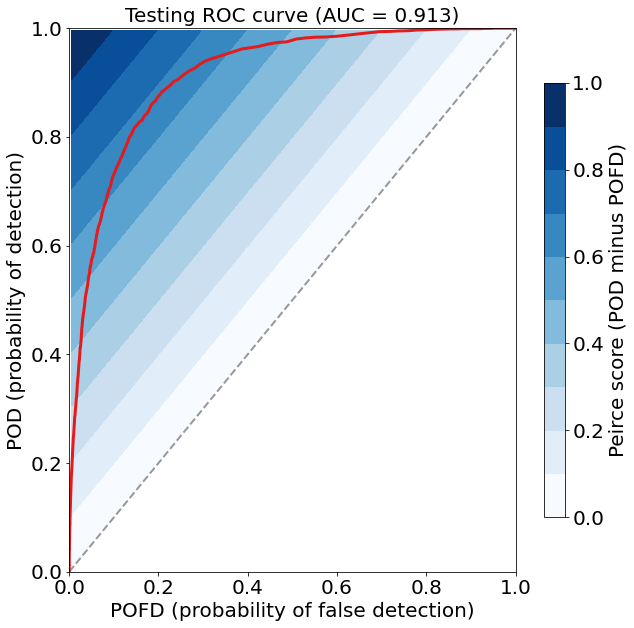

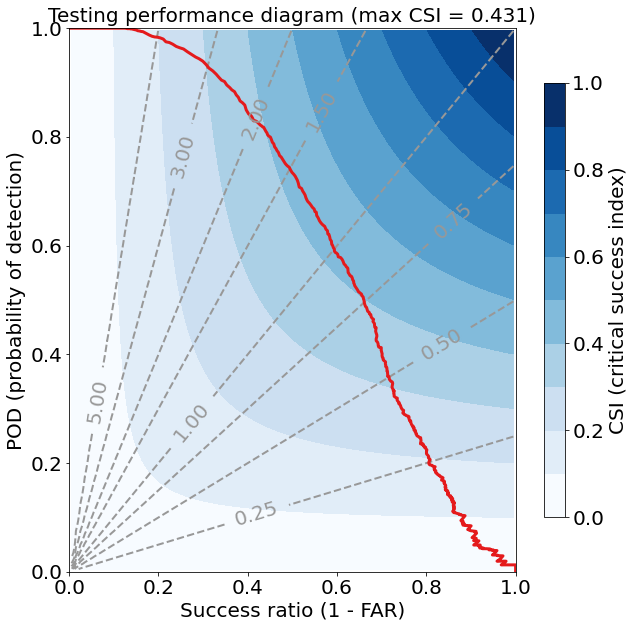

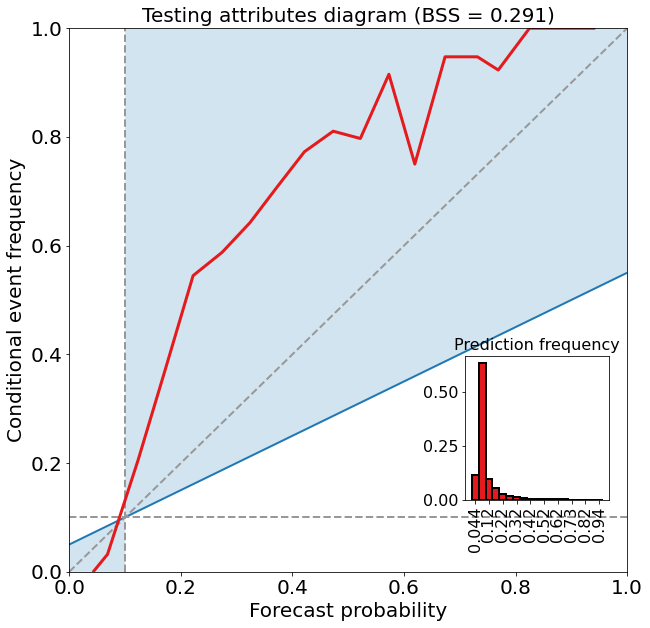

Testing max Peirce score (POD - POFD) = 0.675
Testing AUC (area under ROC curve) = 0.913
Testing max CSI (critical success index) = 0.431
Testing Brier score = 0.064
Testing Brier skill score (improvement over climatology) = 0.291


In [ ]:
best_linear_index = numpy.argmax(numpy.ravel(validation_bss_matrix))

best_dropout_index, best_l2_index = numpy.unravel_index(
    best_linear_index, validation_bss_matrix.shape
)

best_dropout_rate = dropout_rates[best_dropout_index]
best_l2_weight = l2_weights[best_l2_index]
best_validation_bss = numpy.max(validation_bss_matrix)

message_string = (
    'Best validation BSS = {0:.3f} ... corresponding dropout rate = {1:.2f} ...'
    ' L_2 weight = 10^{2:.1f}'
).format(
    best_validation_bss, best_dropout_rate, numpy.log10(best_l2_weight)
)

print(message_string)

num_predictors = len(list(training_predictor_table))
dropout_rate_by_layer = numpy.concatenate((
    numpy.full(4, best_dropout_rate), numpy.array([0.])
))

final_model_object = utils.setup_dense_net(
    num_predictors=num_predictors,
    dropout_rates=dropout_rate_by_layer,
    l2_weight=best_l2_weight
)

utils.train_dense_net(
    model_object=final_model_object,
    output_dir_name='/content/models/dense_net_hyperparam_experiment/final',
    num_epochs=20,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table,
    validation_predictor_table=validation_predictor_table,
    validation_target_table=validation_target_table
)

testing_predictions = utils.apply_neural_net(
    model_object=model_object,
    predictor_matrix=testing_predictor_table.to_numpy(),
    num_examples_per_batch=1024, verbose=True
)
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

_ = utils.eval_binary_classifn(
    observed_labels=
    testing_target_table[utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=testing_predictions,
    training_event_frequency=training_event_frequency,
    create_plots=True, verbose=True, dataset_name='testing'
)

# Permutation importance test (PIT): Theory

 - **The PIT measures the importance of each predictor variable, averaged over all examples in a dataset.**
   - We apply the PIT (and all other interpretation methods) to the testing set, to ensure that results are not influenced by overfitting the training or validation sets.
   - However, some people apply interpretation methods to the training and validation sets as well.
   - There is significant debate over which dataset is most appropriate.
<br><br>

 - **The "importance" of predictor $x_j$ is determined by how much model performance declines when $x_j$ is permuted** (values of $x_j$ are assigned to random examples).
 - If performance declines significantly, $x_j$ is important.
 - If performance does not decline significantly, $x_j$ is either unimportant or highly correlated with other predictors.
<br><br>

 - **The PIT is completely model-agnostic** (can be applied to any machine-learning model, not just FNNs).
 - **There are 4 versions of the PIT (see below).**
 - The 4 versions handle correlated predictors in different ways.
 - It is often beneficial to run all 4 versions and compare the results.

## Single-pass forward test

Let:

 - $F$ be the trained model
 - $\mathbf{X}$ be the clean dataset (with no predictors permuted)
<br><br>

1. Repeat the following for each predictor $x_j$:<br>
  a. Copy the dataset $\mathbf{X}$ to a new variable, $\mathbf{X}'$.<br>
  b. Permute values of $x_j$ over all examples in $\mathbf{X}'$.<br>
  c. Pass $\mathbf{X}'$ through $F$ and record the new loss.<br><br>
2. Rank predictors by loss after permutation.<br>
   In other words, the most important predictor is that whose permutation causes the highest loss.<br>
   More generally, the $k^{\textrm{th}}$-most important predictor is that whose permutation causes the $k^{\textrm{th}}$-highest loss.
<br><br>

For more details, see Breiman (2001).

<center><img src="https://raw.githubusercontent.com/thunderhoser/cira_ml_short_course/master/forward_single_pass_test.gif" width="500"></center>
<center>(Adapted from Supplementary Figure ES5 of McGovern et al. 2019)</center>

## Multi-pass forward test

Let:

 - $F$ be the trained model
 - $\mathbf{X}$ be the clean dataset (with no predictors permuted)
 - $U$ be the set of predictors that are still clean (not yet permuted)
<br><br>

1. Repeat the following for each predictor $x_j \in U$:<br>
  a. Copy the dataset $\mathbf{X}$ to a new variable, $\mathbf{X}'$.<br>
  b. Permute values of $x_j$ over all examples in $\mathbf{X}'$.<br>
  c. Pass $\mathbf{X}'$ through $F$ and record the new loss.<br><br>
2. Find the predictor whose permutation led to the highest loss in step 1.  This is the most important predictor still in $U$.  Call this predictor $x^*$.<br>
3. Remove $x^*$ from $U$ and permanently permute $x^*$ in dataset $\mathbf{X}$.
<br>
4. Repeat steps 1-3 until $U$ is empty (all predictors are permuted in $\mathbf{X}$).
<br>
5. Rank predictors by order in which they were permanently permuted (in $\mathbf{X}$, not $\mathbf{X}'$).<br>
   In other words, the most important predictor is the first to be permanently permuted.<br>
   More generally, the $k^{\textrm{th}}$-most important predictor is the $k^{\textrm{th}}$ to be permanently permuted.
<br><br>

For more details, see Lakshmanan *et al.* (2015).

<center><img src="https://raw.githubusercontent.com/thunderhoser/cira_ml_short_course/master/forward_multi_pass_test.gif" width="500"></center>
<center>(Adapted from Supplementary Figure ES6 of McGovern et al. 2019)</center>

## Single-pass backwards test

Let:

 - $F$ be the trained model
 - $\mathbf{X}_{\textrm{dirty}}$ be the dirty dataset (with all predictors permuted)
<br><br>

1. Repeat the following for each predictor $x_j$:<br>
  a. Copy the dataset $\mathbf{X}_{\textrm{dirty}}$ to a new variable, $\mathbf{X}'$.<br>
  b. Restore values of $x_j$ to their correct order in $\mathbf{X}'$.<br>
  c. Pass $\mathbf{X}'$ through $F$ and record the new loss.<br><br>
2. Rank predictors by loss after restoration.<br>
   In other words, the most important predictor is that whose restoration causes the lowest loss.<br>
   More generally, the $k^{\textrm{th}}$-most important predictor is that whose restoration causes the $k^{\textrm{th}}$-lowest loss.

<center><img src="https://raw.githubusercontent.com/thunderhoser/cira_ml_short_course/master/backwards_single_pass_test.gif" width="500"></center>

## Multi-pass backwards test

Let:

 - $F$ be the trained model
 - $\mathbf{X}$ be the dirty dataset (with all predictors permuted)
 - $U$ be the set of predictors that are still dirty (not yet restored)
<br><br>

1. Repeat the following for each predictor $x_j \in U$:<br>
  a. Copy the dataset $\mathbf{X}$ to a new variable, $\mathbf{X}'$.<br>
  b. Restore values of $x_j$ to their correct order in $\mathbf{X}'$.<br>
  c. Pass $\mathbf{X}'$ through $F$ and record the new loss.<br><br>
2. Find the predictor whose restoration led to the lowest loss in step 1.  This is the most important predictor still in $U$.  Call this predictor $x^*$.<br>
3. Remove $x^*$ from $U$ and permanently restore $x^*$ in dataset $\mathbf{X}$.
<br>
4. Repeat steps 1-3 until $U$ is empty (all predictors are restored in $\mathbf{X}$).
<br>
5. Rank predictors by order in which they were permanently restored (in $\mathbf{X}$, not $\mathbf{X}'$).<br>
   In other words, the most important predictor is the first to be permanently restored.<br>
   More generally, the $k^{\textrm{th}}$-most important predictor is the $k^{\textrm{th}}$ to be permanently restored.

<center><img src="https://raw.githubusercontent.com/thunderhoser/cira_ml_short_course/master/backwards_multi_pass_test.gif" width="500"></center>

# <font color='red'>Read pre-trained neural network (required)</font>

The next cell reads a pre-trained neural network, to which interpretation methods (the permutation importance test and saliency maps) will be applied.

In [ ]:
pretrained_model_file_name = (
    '/content/course_repository/dense_net_for_interpretation/model.h5'
)

pretrained_model_object = utils.read_dense_net(pretrained_model_file_name)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# Permutation importance test (PIT): Code

## Run forward versions of test

 - The next cell runs both forward versions (single-pass and multi-pass) of the permutation importance test.
 - **The loss function is negative AUC (area under ROC curve).**
 - At each step, the code computes a 95% confidence interval for the loss, using 1000 bootstrap replicates.
 - **In each figure, the most (least) important predictor is at the top (bottom)**.
<br><br>

 - To save computing time, we use only the first 2000 testing examples.
 - To declutter the figures, we plot only the 20 (out of 41) most important predictors.

In [ ]:
testing_classes = testing_target_table[utils.BINARIZED_TARGET_NAME].values
negative_indices = numpy.where(testing_classes == 0)[0][:1000]
positive_indices = numpy.where(testing_classes == 1)[0][:1000]
example_indices = numpy.concatenate((negative_indices, positive_indices))

numpy.random.shuffle(example_indices)

small_testing_predictor_table = testing_predictor_table.iloc[example_indices]
small_testing_target_table = testing_target_table.iloc[example_indices]

forward_result_dict = utils.run_forward_test(
    predictor_matrix=small_testing_predictor_table.to_numpy(),
    predictor_names=list(small_testing_predictor_table),
    target_classes=
    small_testing_target_table[utils.BINARIZED_TARGET_NAME].values,
    model_object=pretrained_model_object
)

Finding original cost (before permutation)...
Average cost estimate over 1000 replicates = -0.945036


--------------------------------------------------


Permuting 1th of 41 predictors...
Average cost estimate over 1000 replicates = -0.941563
Permuting 2th of 41 predictors...
Average cost estimate over 1000 replicates = -0.934520
Permuting 3th of 41 predictors...
Average cost estimate over 1000 replicates = -0.944989
Permuting 4th of 41 predictors...
Average cost estimate over 1000 replicates = -0.943972
Permuting 5th of 41 predictors...
Average cost estimate over 1000 replicates = -0.941948
Permuting 6th of 41 predictors...
Average cost estimate over 1000 replicates = -0.940557
Permuting 7th of 41 predictors...
Average cost estimate over 1000 replicates = -0.943796
Permuting 8th of 41 predictors...
Average cost estimate over 1000 replicates = -0.943161
Permuting 9th of 41 predictors...
Average cost estimate over 1000 replicates = -0.942056
Permuting 10th of 41 predictors...
Average 

## Plot results

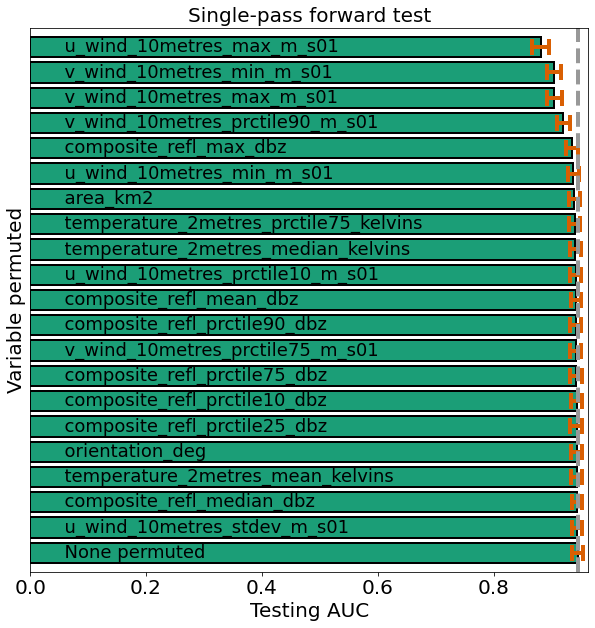

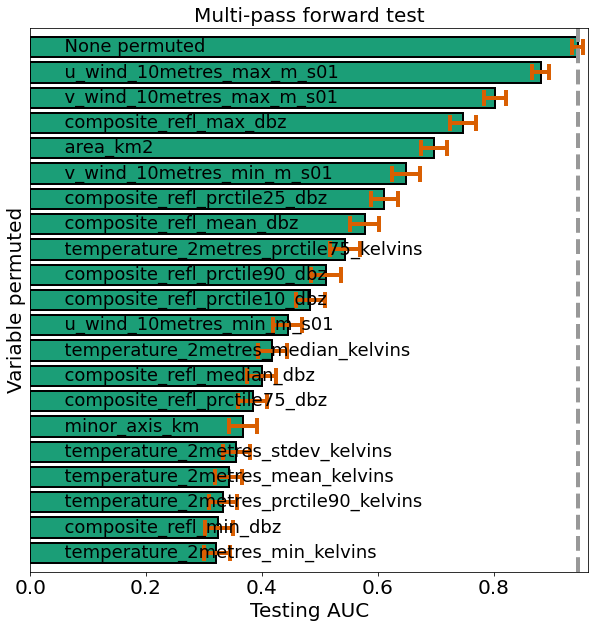

In [ ]:
axes_object = permutation_plotting.plot_single_pass_test(
    result_dict=forward_result_dict, num_predictors_to_plot=20
)
axes_object.set_title('Single-pass forward test')
axes_object.set_xlabel('Testing AUC')
pyplot.show()
print('\n\n')

axes_object = permutation_plotting.plot_multipass_test(
    result_dict=forward_result_dict, num_predictors_to_plot=20
)
axes_object.set_title('Multi-pass forward test')
axes_object.set_xlabel('Testing AUC')
pyplot.show()

## Run backwards versions of test

 - The next cell runs both backwards versions (single-pass and multi-pass) of the permutation importance test.
 - **In each figure, the most (least) important predictor is at the top (bottom)**.

In [ ]:
testing_classes = testing_target_table[utils.BINARIZED_TARGET_NAME].values
negative_indices = numpy.where(testing_classes == 0)[0][:1000]
positive_indices = numpy.where(testing_classes == 1)[0][:1000]
example_indices = numpy.concatenate((negative_indices, positive_indices))

numpy.random.shuffle(example_indices)

small_testing_predictor_table = testing_predictor_table.iloc[example_indices]
small_testing_target_table = testing_target_table.iloc[example_indices]

backwards_result_dict = utils.run_backwards_test(
    predictor_matrix=small_testing_predictor_table.to_numpy(),
    predictor_names=list(small_testing_predictor_table),
    target_classes=
    small_testing_target_table[utils.BINARIZED_TARGET_NAME].values,
    model_object=pretrained_model_object
)

Finding cost on clean data (before permutation)...
Average cost estimate over 1000 replicates = -0.931211
Finding cost on dirty data (before *de*permutation)...
Average cost estimate over 1000 replicates = -0.557967


--------------------------------------------------


Depermuting 1th of 41 predictors...
Average cost estimate over 1000 replicates = -0.583243
Depermuting 2th of 41 predictors...
Average cost estimate over 1000 replicates = -0.616347
Depermuting 3th of 41 predictors...
Average cost estimate over 1000 replicates = -0.558694
Depermuting 4th of 41 predictors...
Average cost estimate over 1000 replicates = -0.529598
Depermuting 5th of 41 predictors...
Average cost estimate over 1000 replicates = -0.571950
Depermuting 6th of 41 predictors...
Average cost estimate over 1000 replicates = -0.578529
Depermuting 7th of 41 predictors...
Average cost estimate over 1000 replicates = -0.575823
Depermuting 8th of 41 predictors...
Average cost estimate over 1000 replicates = -0.570057
D

## Plot results

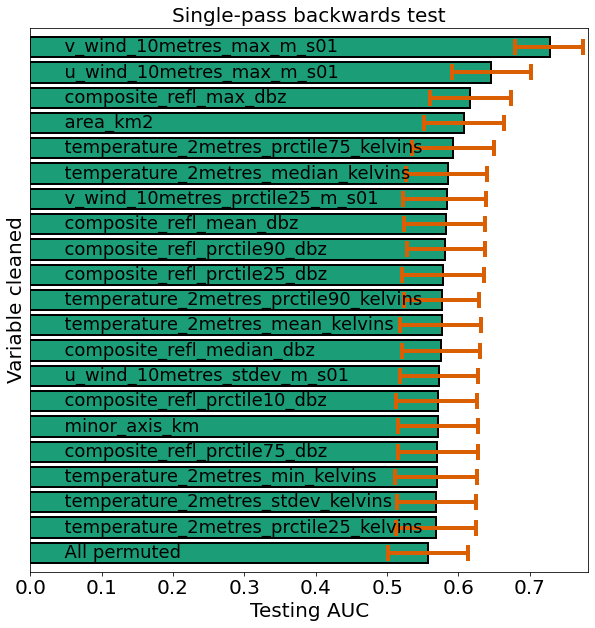

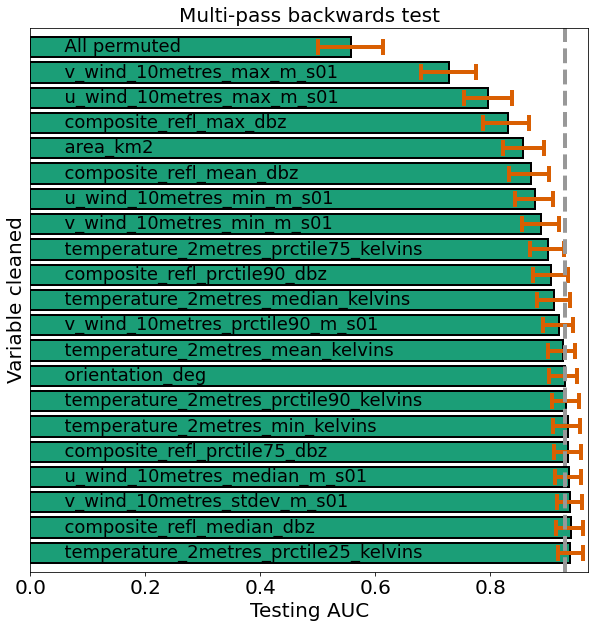

In [ ]:
axes_object = permutation_plotting.plot_single_pass_test(
    result_dict=backwards_result_dict, num_predictors_to_plot=20
)
axes_object.set_title('Single-pass backwards test')
axes_object.set_xlabel('Testing AUC')
pyplot.show()
print('\n\n')

axes_object = permutation_plotting.plot_multipass_test(
    result_dict=backwards_result_dict, num_predictors_to_plot=20
)
axes_object.set_title('Multi-pass backwards test')
axes_object.set_xlabel('Testing AUC')
pyplot.show()

# Saliency maps

## Theory

**Saliency (Simonyan *et al.* 2014) is defined as follows:**

<center>$s = \frac{\partial a}{\partial x} \bigg \rvert_{x = x_0}$</center>

 - $a$ is the activation of a neuron in the model
 - $x$ is one predictor
 - $x_0$ is the value of $x$ in a real example
<br><br>

 - Thus, saliency is a linear approximation to $\frac{\partial a}{\partial x}$, linearized around the $x$-value that occurs in the example.
 - **This can be computed for all predictors $x$, resulting in a map.**
<br><br>

 - **$a$ is often the activation of an output neuron, which is a prediction.**
 - In this notebook, there is only one output neuron and its activation is probability of strong future rotation.
 - Thus, our saliency maps quantify the sensitivity of strong-rotation probability to each input.
 - **Thus, our saliency maps answer the question: "How would you perturb the storm to increase/decrease the probability of strong future rotation?"**
<br><br>
 - In general, $a$ could also be the activation of a neuron in a hidden layer.

## Run

 - For each testing example, the next cell computes saliency for the output neuron with respect to each predictor.
 - In other words, we compute the following equation for each predictor $x$ in each testing example, where $p$ is the probability of strong future rotation:
<center>$s = \frac{\partial p}{\partial x} \bigg \rvert_{x = x_0}$</center>
<br><br>
 - Then we plot the average saliency for each predictor (*i.e.*, averaged over all testing examples).

In [ ]:
saliency_matrix = utils.get_saliency_one_neuron(
    model_object=pretrained_model_object,
    predictor_matrix=testing_predictor_table.to_numpy(),
    layer_name=pretrained_model_object.layers[-1].name,
    neuron_indices=numpy.array([0], dtype=int),
    ideal_activation=1.
)

Have computed saliency maps for 0 of 19368 examples...
Have computed saliency maps for 100 of 19368 examples...
Have computed saliency maps for 200 of 19368 examples...
Have computed saliency maps for 300 of 19368 examples...
Have computed saliency maps for 400 of 19368 examples...
Have computed saliency maps for 500 of 19368 examples...
Have computed saliency maps for 600 of 19368 examples...
Have computed saliency maps for 700 of 19368 examples...
Have computed saliency maps for 800 of 19368 examples...
Have computed saliency maps for 900 of 19368 examples...
Have computed saliency maps for 1000 of 19368 examples...
Have computed saliency maps for 1100 of 19368 examples...
Have computed saliency maps for 1200 of 19368 examples...
Have computed saliency maps for 1300 of 19368 examples...
Have computed saliency maps for 1400 of 19368 examples...
Have computed saliency maps for 1500 of 19368 examples...
Have computed saliency maps for 1600 of 19368 examples...
Have computed saliency map

## Plot results

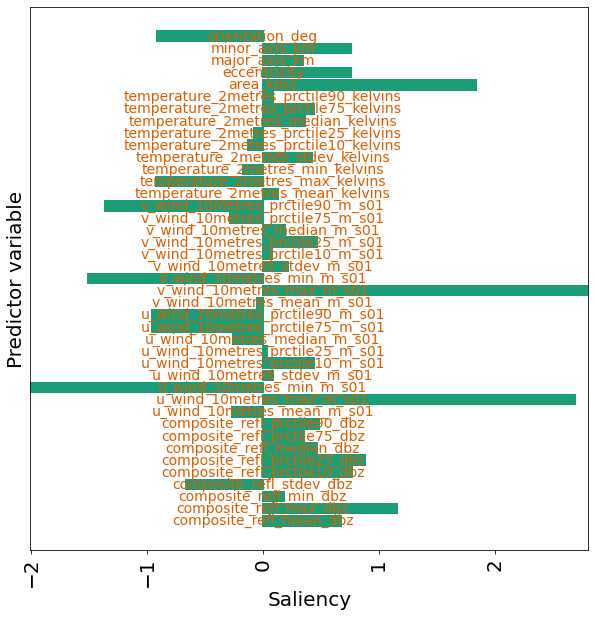

In [ ]:
utils.plot_saliency(
    saliency_values=numpy.mean(saliency_matrix, axis=0),
    predictor_names=list(testing_predictor_table)
)

pyplot.show()